# 🎭 Facial Emotion Recognition v2.0 - Colab Training

**Architecture**: EfficientNetV2-S | **Dataset**: FER-2013 | **GPU**: T4

## What This Notebook Does

1. ✅ Mounts Google Drive (models auto-save)
2. ✅ Creates project structure locally (fast)
3. ✅ Trains with SOTA techniques
4. ✅ Saves results to your Drive

**Storage**: Training runs locally (fast), models save to Drive (persistent)

## 🔧 Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print('✅ Drive mounted')

Mounted at /content/drive
✅ Drive mounted


In [2]:
# Verify GPU
import torch

if torch.cuda.is_available():
    print(f'✅ GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    print('❌ No GPU! Go to Runtime > Change runtime type > T4 GPU')
    raise RuntimeError('GPU required for training')

✅ GPU: Tesla T4
Memory: 15.8 GB


In [3]:
# Install dependencies
!pip install -q timm==0.9.12 albumentations==1.3.1 onnx==1.15.0
print('✅ Dependencies installed')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 122.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 11.7 MB/s eta 0:00:00
✅ Dependencies installed


## 📂 Project Setup with Drive Symlinks

In [4]:
import os
from pathlib import Path

# Create Drive folders (persistent)
drive_base = Path('/content/drive/MyDrive/Emotion_Detection_v2')
drive_models = drive_base / 'models'
drive_results = drive_base / 'results'
drive_models.mkdir(parents=True, exist_ok=True)
drive_results.mkdir(parents=True, exist_ok=True)

# Create local project
project_dir = Path('/content/emotion_detection_v2')
project_dir.mkdir(exist_ok=True)
(project_dir / 'src' / 'models').mkdir(parents=True, exist_ok=True)
(project_dir / 'src' / 'data').mkdir(parents=True, exist_ok=True)
(project_dir / 'src' / 'utils').mkdir(parents=True, exist_ok=True)
(project_dir / 'data').mkdir(exist_ok=True)

# Create symlinks to Drive
local_models = project_dir / 'models'
local_results = project_dir / 'results'
if local_models.exists() and local_models.is_symlink():
    local_models.unlink()
if local_results.exists() and local_results.is_symlink():
    local_results.unlink()
local_models.symlink_to(drive_models)
local_results.symlink_to(drive_results)

print('✅ Project structure created')
print(f'   Models → Drive: {drive_models}')
print(f'   Results → Drive: {drive_results}')
print('\n💡 All models and results will auto-save to your Google Drive!')

%cd /content/emotion_detection_v2

✅ Project structure created
   Models → Drive: /content/drive/MyDrive/Emotion_Detection_v2/models
   Results → Drive: /content/drive/MyDrive/Emotion_Detection_v2/results

💡 All models and results will auto-save to your Google Drive!
/content/emotion_detection_v2


## 📥 Load Dataset

**Choose ONE option below:**

In [5]:
# Option 1: Kaggle Download (requires kaggle.json)
# Upload your kaggle.json to Drive first, then uncomment:

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013 -p data/ --unzip
print('✅ FER-2013 downloaded from Kaggle')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.24GB/s]
✅ FER-2013 downloaded from Kaggle


In [6]:
# Verify data structure
!ls -lh data/
!ls data/train/ 2>/dev/null || ls data/Test/ 2>/dev/null || echo '⚠️ Check data structure'

total 8.0K
drwxr-xr-x 9 root root 4.0K Nov 27 13:33 test
drwxr-xr-x 9 root root 4.0K Nov 27 13:33 train
angry  disgust	fear  happy  neutral  sad  surprise


## 📝 Create Source Code

In [7]:
# Create package files
!touch src/__init__.py src/models/__init__.py src/data/__init__.py src/utils/__init__.py

In [8]:
%%writefile src/models/efficientnet.py
"""EfficientNetV2 for emotion recognition"""
import torch
import torch.nn as nn
import timm

class EmotionEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnetv2_s', num_classes=7, pretrained=True, dropout=0.3):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        self.num_features = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.num_features, num_classes)
        )
        self._init_classifier()

    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.classifier(self.backbone(x))

    def get_params_groups(self, lr, backbone_lr_mult=0.1):
        return [
            {'params': self.backbone.parameters(), 'lr': lr * backbone_lr_mult},
            {'params': self.classifier.parameters(), 'lr': lr}
        ]

def create_model(model_name='tf_efficientnetv2_s', num_classes=7, pretrained=True, dropout=0.3):
    return EmotionEfficientNet(model_name, num_classes, pretrained, dropout)

Writing src/models/efficientnet.py


In [9]:
%%writefile src/data/dataset.py
"""Dataset loader"""
from pathlib import Path
from PIL import Image
import numpy as np
from torch.utils.data import Dataset

EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

class EmotionDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.transform = transform
        self.samples = self._load(Path(data_dir) / split)
        print(f'Loaded {len(self.samples)} {split} samples')

    def _load(self, split_dir):
        samples = []
        for emotion_dir in sorted(split_dir.iterdir()):
            if not emotion_dir.is_dir():
                continue
            label = self._get_label(emotion_dir.name)
            for ext in ['*.jpg', '*.png']:
                for img_path in emotion_dir.glob(ext):
                    samples.append((str(img_path), label))
        return samples

    def _get_label(self, name):
        mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
        return mapping.get(name.lower(), 0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

Writing src/data/dataset.py


In [10]:
%%writefile src/data/transforms.py
"""Data augmentation"""
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_train_transforms(img_size=224):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.OneOf([A.MotionBlur(p=1), A.GaussianBlur(p=1)], p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=img_size//10, max_width=img_size//10, p=0.3),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

def get_val_transforms(img_size=224):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

class AlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        if hasattr(image, 'convert'):
            image = np.array(image.convert('RGB'))
        return self.transform(image=image)['image']

Writing src/data/transforms.py


In [11]:
%%writefile src/utils/training_utils.py
"""Training utilities"""
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class ExponentialMovingAverage:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {n: p.data.clone() for n, p in model.named_parameters() if p.requires_grad}

    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = self.decay * self.shadow[n] + (1 - self.decay) * p.data

    def apply_shadow(self, model):
        self.backup = {n: p.data.clone() for n, p in model.named_parameters() if p.requires_grad}
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data = self.shadow[n]

    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data = self.backup[n]

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_class = pred.size(1)
        if target.dim() == 1:
            target = torch.nn.functional.one_hot(target, n_class).float()
        target = target * (1 - self.smoothing) + self.smoothing / n_class
        return -(target * torch.nn.functional.log_softmax(pred, 1)).sum(1).mean()

class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = self.avg = self.sum = self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def compute_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }

def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    cm = confusion_matrix(y_true, y_pred).astype('float')
    cm = cm / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Confusion Matrix')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

Writing src/utils/training_utils.py


## 🚀 Training

In [12]:
import sys
sys.path.insert(0, '/content/emotion_detection_v2')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

from src.models.efficientnet import create_model
from src.data.dataset import EmotionDataset, EMOTION_LABELS
from src.data.transforms import get_train_transforms, get_val_transforms, AlbumentationsWrapper
from src.utils.training_utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using {device}')

✅ Using cuda


In [13]:
# Configuration
CONFIG = {
    'img_size': 224,
    'batch_size': 64,  # Reduce to 32 if GPU OOM
    'epochs': 50,      # Try 30 for faster testing
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'label_smoothing': 0.1,
    'ema_decay': 0.9995,
    'warmup_epochs': 5,
}

print('Configuration:', CONFIG)

Configuration: {'img_size': 224, 'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'ema_decay': 0.9995, 'warmup_epochs': 5}


In [14]:
# Load datasets
train_dataset = EmotionDataset('data', 'train', AlbumentationsWrapper(get_train_transforms(CONFIG['img_size'])))
# Try 'test' or 'Test' depending on your folder structure
val_dataset = EmotionDataset('data', 'test', AlbumentationsWrapper(get_val_transforms(CONFIG['img_size'])))

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Batches: {len(train_loader)}')

Loaded 28709 train samples
Loaded 7178 test samples
Train: 28709, Val: 7178, Batches: 448


In [15]:
# Create model
model = create_model().to(device)
criterion = LabelSmoothingCrossEntropy(CONFIG['label_smoothing'])
optimizer = torch.optim.AdamW(model.get_params_groups(CONFIG['lr'], 0.1), weight_decay=CONFIG['weight_decay'])

from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
warmup = LinearLR(optimizer, start_factor=0.1, total_iters=CONFIG['warmup_epochs']*len(train_loader))
cosine = CosineAnnealingLR(optimizer, T_max=(CONFIG['epochs']-CONFIG['warmup_epochs'])*len(train_loader), eta_min=1e-6)
scheduler = SequentialLR(optimizer, [warmup, cosine], [CONFIG['warmup_epochs']*len(train_loader)])

ema = ExponentialMovingAverage(model, CONFIG['ema_decay'])
scaler = torch.cuda.amp.GradScaler()

print(f'✅ Model: {sum(p.numel() for p in model.parameters())/1e6:.1f}M params')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

✅ Model: 20.2M params


/tmp/ipython-input-2318121991.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [16]:
# Training functions
def train_epoch(model, loader, criterion, optimizer, scheduler, scaler, ema):
    model.train()
    loss_meter = AverageMeter()
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = criterion(logits, labels)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        ema.update(model)
        loss_meter.update(loss.item(), images.size(0))
    return loss_meter.avg

@torch.no_grad()
def validate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for images, labels in tqdm(loader, desc='Validating', leave=False):
        images = images.to(device)
        logits = model(images)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())
    return compute_metrics(np.array(all_labels), np.array(all_preds)), np.array(all_preds), np.array(all_labels)

In [17]:
# Training loop
best_f1 = 0
history = {'train_loss': [], 'val_f1': [], 'ema_val_f1': []}

for epoch in range(CONFIG['epochs']):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, ema)
    val_metrics, _, _ = validate(model, val_loader)

    ema.apply_shadow(model)
    ema_metrics, _, _ = validate(model, val_loader)
    ema.restore(model)

    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_metrics['f1_macro'])
    history['ema_val_f1'].append(ema_metrics['f1_macro'])

    print(f"Epoch {epoch+1}/{CONFIG['epochs']}: Loss={train_loss:.4f}, F1={val_metrics['f1_macro']:.4f}, EMA F1={ema_metrics['f1_macro']:.4f}")

    if ema_metrics['f1_macro'] > best_f1:
        best_f1 = ema_metrics['f1_macro']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'ema_shadow': ema.shadow,
            'best_f1': best_f1
        }, 'models/best_model.pth')
        print(f'  ✅ Saved best model (F1={best_f1:.4f}) to Drive!')

print(f'\n✅ Training complete! Best F1: {best_f1:.4f}')

Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:42<00:00,  2.75it/s]


Epoch 1/50: Loss=1.9193, F1=0.3934, EMA F1=0.1007
  ✅ Saved best model (F1=0.1007) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:46<00:00,  2.68it/s]


Epoch 2/50: Loss=1.4304, F1=0.4934, EMA F1=0.1303
  ✅ Saved best model (F1=0.1303) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.80it/s]


Epoch 3/50: Loss=1.2389, F1=0.5846, EMA F1=0.1938
  ✅ Saved best model (F1=0.1938) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 4/50: Loss=1.1295, F1=0.6357, EMA F1=0.2991
  ✅ Saved best model (F1=0.2991) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.82it/s]


Epoch 5/50: Loss=1.0472, F1=0.6571, EMA F1=0.4483
  ✅ Saved best model (F1=0.4483) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 6/50: Loss=0.9621, F1=0.6767, EMA F1=0.5000
  ✅ Saved best model (F1=0.5000) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:40<00:00,  2.79it/s]


Epoch 7/50: Loss=0.8776, F1=0.6925, EMA F1=0.5746
  ✅ Saved best model (F1=0.5746) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.81it/s]


Epoch 8/50: Loss=0.8031, F1=0.6910, EMA F1=0.6055
  ✅ Saved best model (F1=0.6055) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.80it/s]


Epoch 9/50: Loss=0.7410, F1=0.6849, EMA F1=0.6184
  ✅ Saved best model (F1=0.6184) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.81it/s]


Epoch 10/50: Loss=0.6995, F1=0.6983, EMA F1=0.6627
  ✅ Saved best model (F1=0.6627) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:40<00:00,  2.79it/s]


Epoch 11/50: Loss=0.6600, F1=0.6936, EMA F1=0.6498


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 12/50: Loss=0.6313, F1=0.6927, EMA F1=0.6857
  ✅ Saved best model (F1=0.6857) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.81it/s]


Epoch 13/50: Loss=0.6113, F1=0.6976, EMA F1=0.7031
  ✅ Saved best model (F1=0.7031) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:40<00:00,  2.79it/s]


Epoch 14/50: Loss=0.5965, F1=0.7067, EMA F1=0.6896


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 15/50: Loss=0.5830, F1=0.7004, EMA F1=0.7143
  ✅ Saved best model (F1=0.7143) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.81it/s]


Epoch 16/50: Loss=0.5704, F1=0.6989, EMA F1=0.7053


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.87it/s]


Epoch 17/50: Loss=0.5611, F1=0.6991, EMA F1=0.7145
  ✅ Saved best model (F1=0.7145) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.81it/s]


Epoch 18/50: Loss=0.5541, F1=0.7008, EMA F1=0.7197
  ✅ Saved best model (F1=0.7197) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.82it/s]


Epoch 19/50: Loss=0.5413, F1=0.7041, EMA F1=0.7200
  ✅ Saved best model (F1=0.7200) to Drive!


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:39<00:00,  2.82it/s]


Epoch 20/50: Loss=0.5374, F1=0.7030, EMA F1=0.7170


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 21/50: Loss=0.5298, F1=0.7009, EMA F1=0.7151


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.85it/s]


Epoch 22/50: Loss=0.5207, F1=0.6959, EMA F1=0.7198


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 23/50: Loss=0.5194, F1=0.7033, EMA F1=0.7198


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 24/50: Loss=0.5124, F1=0.7021, EMA F1=0.7183


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 25/50: Loss=0.5054, F1=0.7006, EMA F1=0.7151


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 26/50: Loss=0.5056, F1=0.6918, EMA F1=0.7157


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 27/50: Loss=0.5006, F1=0.7002, EMA F1=0.7128


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 28/50: Loss=0.4941, F1=0.7066, EMA F1=0.7119


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 29/50: Loss=0.4918, F1=0.6995, EMA F1=0.7122


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.82it/s]


Epoch 30/50: Loss=0.4891, F1=0.6998, EMA F1=0.7082


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 31/50: Loss=0.4857, F1=0.6946, EMA F1=0.7043


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 32/50: Loss=0.4821, F1=0.7059, EMA F1=0.7082


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.86it/s]


Epoch 33/50: Loss=0.4808, F1=0.7056, EMA F1=0.7095


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]


Epoch 34/50: Loss=0.4766, F1=0.7076, EMA F1=0.7091


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 35/50: Loss=0.4755, F1=0.7048, EMA F1=0.7123


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 36/50: Loss=0.4738, F1=0.7111, EMA F1=0.7149


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.86it/s]


Epoch 37/50: Loss=0.4701, F1=0.7134, EMA F1=0.7147


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.87it/s]


Epoch 38/50: Loss=0.4695, F1=0.7147, EMA F1=0.7116


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.86it/s]


Epoch 39/50: Loss=0.4691, F1=0.7062, EMA F1=0.7115


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.85it/s]


Epoch 40/50: Loss=0.4677, F1=0.7094, EMA F1=0.7118


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 41/50: Loss=0.4664, F1=0.7109, EMA F1=0.7133


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 42/50: Loss=0.4647, F1=0.7112, EMA F1=0.7143


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 43/50: Loss=0.4644, F1=0.7100, EMA F1=0.7120


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.85it/s]


Epoch 44/50: Loss=0.4632, F1=0.7102, EMA F1=0.7131


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.85it/s]


Epoch 45/50: Loss=0.4639, F1=0.7130, EMA F1=0.7166


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.86it/s]


Epoch 46/50: Loss=0.4617, F1=0.7105, EMA F1=0.7143


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 47/50: Loss=0.4623, F1=0.7119, EMA F1=0.7141


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:36<00:00,  2.85it/s]


Epoch 48/50: Loss=0.4612, F1=0.7134, EMA F1=0.7117


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:37<00:00,  2.84it/s]


Epoch 49/50: Loss=0.4617, F1=0.7121, EMA F1=0.7122


Training:   0%|          | 0/448 [00:00<?, ?it/s]/tmp/ipython-input-1107928674.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 448/448 [02:38<00:00,  2.83it/s]
                                                             

Epoch 50/50: Loss=0.4606, F1=0.7136, EMA F1=0.7110

✅ Training complete! Best F1: 0.7200


## 📊 Evaluation

In [18]:
# Load best model
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
for n, p in model.named_parameters():
    if n in checkpoint['ema_shadow']:
        p.data = checkpoint['ema_shadow'][n]

test_metrics, test_preds, test_labels = validate(model, val_loader)

print('\n' + '='*50)
print('FINAL TEST RESULTS')
print('='*50)
print(f"Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"F1 Macro: {test_metrics['f1_macro']:.4f}")
print(f"F1 Weighted: {test_metrics['f1_weighted']:.4f}")

with open('results/test_results.txt', 'w') as f:
    f.write(f"Test Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"F1 Macro: {test_metrics['f1_macro']:.4f}\n")
    f.write(f"F1 Weighted: {test_metrics['f1_weighted']:.4f}\n")

print('\n✅ Results saved to Drive!')


FINAL TEST RESULTS
Accuracy: 0.7268 (72.68%)
F1 Macro: 0.7200
F1 Weighted: 0.7252

✅ Results saved to Drive!


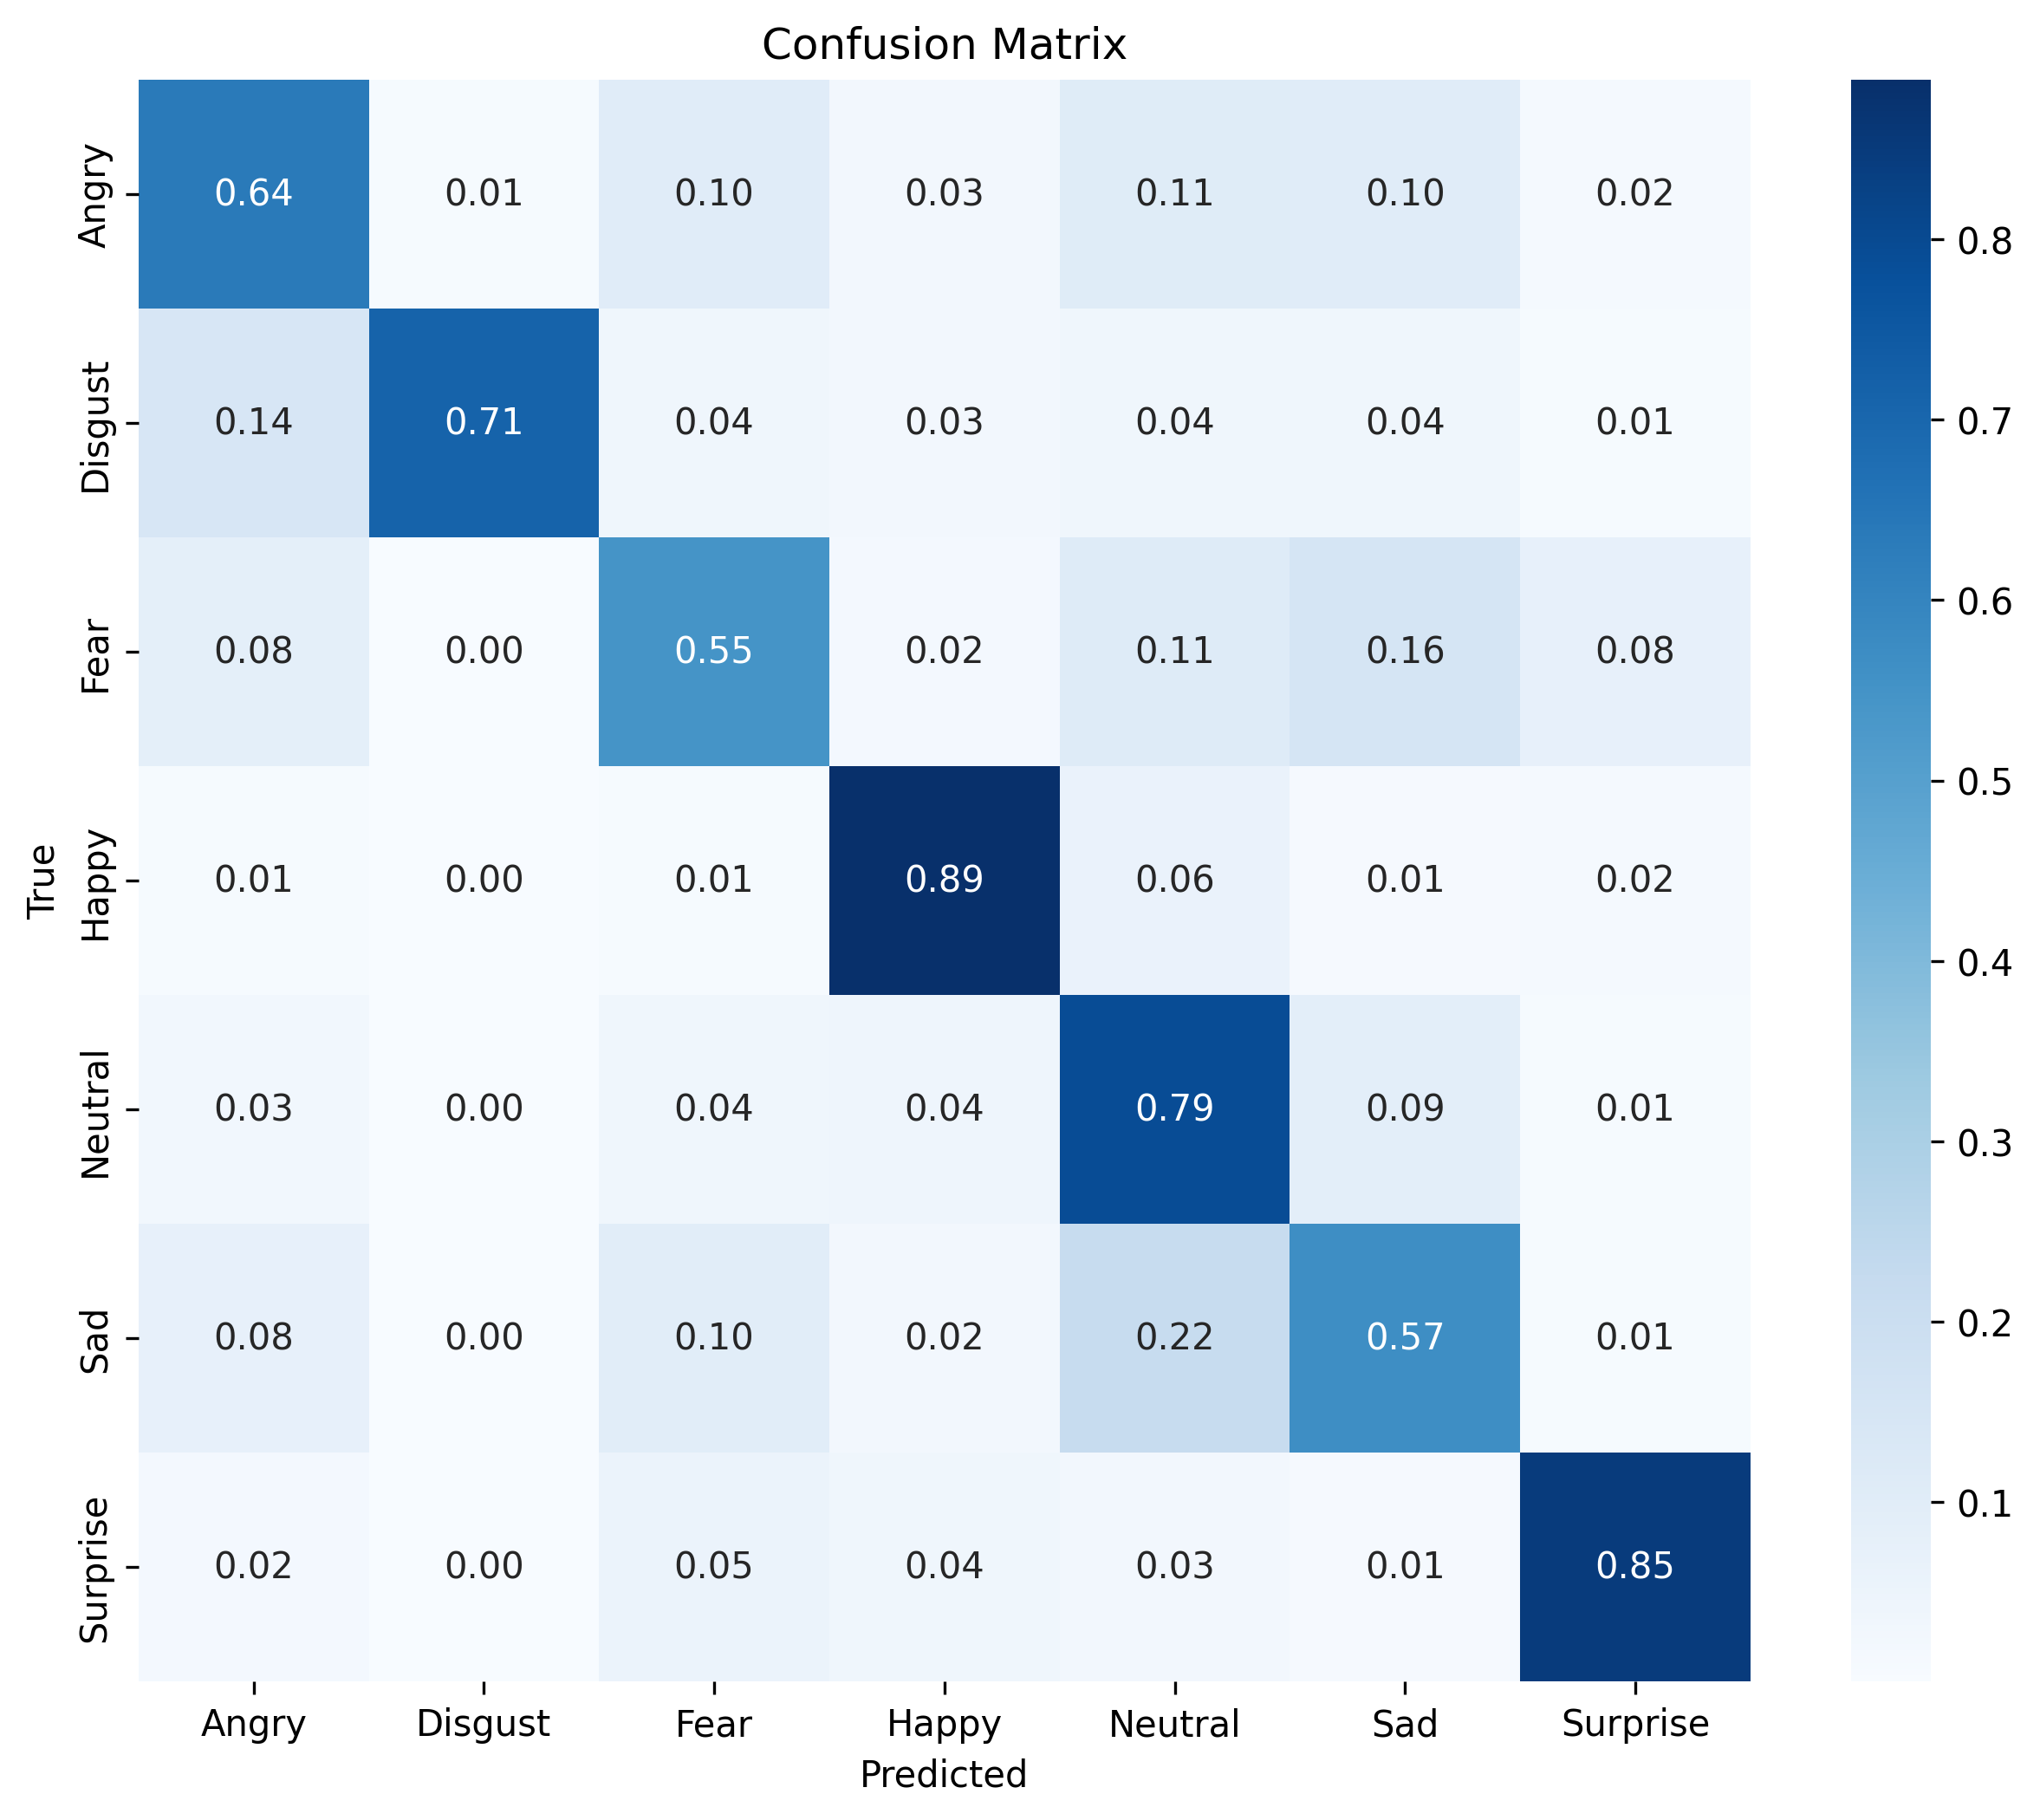

✅ Confusion matrix saved!


In [19]:
# Confusion matrix
class_names = [EMOTION_LABELS[i] for i in range(7)]
plot_confusion_matrix(test_labels, test_preds, class_names, 'results/confusion_matrix.png')

from IPython.display import Image, display
display(Image('results/confusion_matrix.png'))
print('✅ Confusion matrix saved!')

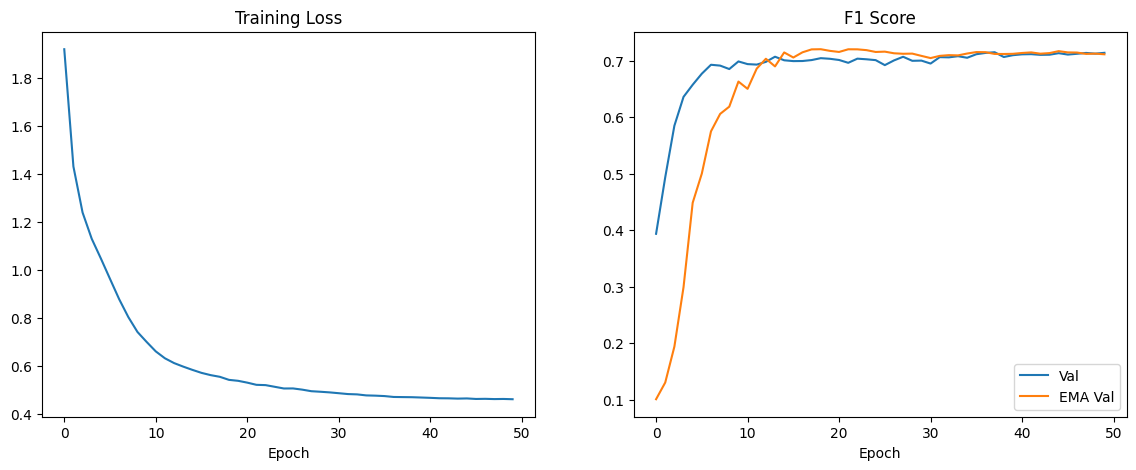

✅ Training curves saved!


In [20]:
# Training curves
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(history['train_loss'])
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[1].plot(history['val_f1'], label='Val')
ax[1].plot(history['ema_val_f1'], label='EMA Val')
ax[1].set_title('F1 Score')
ax[1].set_xlabel('Epoch')
ax[1].legend()
plt.savefig('results/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Training curves saved!')

## 💾 Export to ONNX

In [23]:
!pip install onnxscript
# Export to ONNX
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(
    model, dummy_input, 'models/emotion_model.onnx',
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}}
)

print('✅ ONNX model exported!')
print('\n📂 Files in your Drive:')
!ls -lh /content/drive/MyDrive/Emotion_Detection_v2/models/
!ls -lh /content/drive/MyDrive/Emotion_Detection_v2/results/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.15.0
    Uninstalling onnx-1.15.0:
      Successfully uninstalled onnx-1.15.0


/tmp/ipython-input-2870254493.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `EmotionEfficientNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EmotionEfficientNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 225 of general pattern rewrite rules.
✅ ONNX model exported!

📂 Files in your Drive:
total 233M
-rw------- 1 root root 156M Nov 27 14:39 best_model.pth
-rw------- 1 root root 999K Nov 27 16:30 emotion_model.onnx
-rw------- 1 root root  77M Nov 27 16:30 emotion_model.onnx.data
total 355K
-rw------- 1 root root 211K Nov 27 16:25 confusion_matrix.png
-rw------- 1 root root   59 Nov 27 16:25 test_results.txt
-rw------- 1 root root 144K Nov 27 16:25 training_curves.png


## ✅ Complete!

**Saved to Google Drive** (`/Emotion_Detection_v2/`):
- ✅ `models/best_model.pth` - Best checkpoint
- ✅ `models/emotion_model.onnx` - ONNX export
- ✅ `results/confusion_matrix.png`
- ✅ `results/training_curves.png`
- ✅ `results/test_results.txt`

Download these from your Drive for local use!